# Assignment 8
In this assignment, we implement the Delay-and-Sum (DAS) algorithm that is commonly used for ultrasound image recontruction.

### Initializations and necessary helper functions

In [524]:
# performing the necessary imports
import numpy as np
import matplotlib.pyplot as plt

In [525]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200

# Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by pitch and Nmics
src = (0, 0)
# Spacing between microphones
pitch = 0.1
# proxy for sampling rate
dist_per_samp = 0.1
# Speed of sound in the medium
C = 2.0
# Time dilation factor for sinc pulse: how narrow
SincP = 5.0
# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)
# Location of point obstacle
obstacle = (3, -1)

In [526]:
# coordinates of mics
print(mics)

[-3.15 -3.05 -2.95 -2.85 -2.75 -2.65 -2.55 -2.45 -2.35 -2.25 -2.15 -2.05
 -1.95 -1.85 -1.75 -1.65 -1.55 -1.45 -1.35 -1.25 -1.15 -1.05 -0.95 -0.85
 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35
  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15  1.25  1.35  1.45  1.55
  1.65  1.75  1.85  1.95  2.05  2.15  2.25  2.35  2.45  2.55  2.65  2.75
  2.85  2.95  3.05  3.15]


In [527]:
# Source sound wave - time axis and wave
# sinc wave with narrowness determined by parameter
t = Nsamp * dist_per_samp / C # Nsamp time instants with spacing of dist_per_samp
def wsrc(t):
    return np.sinc(SincP*t)

We define a function to return the distace lag when a sound wave travels from a source to an obstacle, gets reflected and reaches a mic

In [528]:
# Distance from src to a mic after reflecting through pt
def dist(src, pt, mic):
    d1 = np.sqrt((src[0] - pt[0]) ** 2 + (src[1] - pt[1]) ** 2) # distance from src to pt
    d2 = np.sqrt(pt[0] ** 2 + (mic - pt[1]) ** 2) # distance from pt to mic
    return d1 + d2

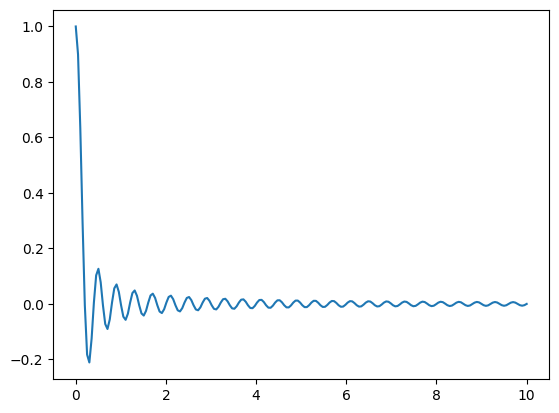

In [529]:
# visualization of the incident wave
x = np.linspace(0, t, Nsamp)
y = wsrc(x)
plt.plot(x, y)

#### Question
Q: The plots below show two example sinc pulses. How will you generate pulses that look like this? Which parameter should be changed? What effect do you think this will have on the final image? \
A: The parameter to be changed is `Sincp`, which determines the narrowness of the sinc wave. As it increases, there is a higher change in the sinc parameter, resulting in faster variations, and quicker dying out of the oscillations, making it more narrow. Higher the value of `SincP`, stronger is the peak and more quickly do the oscillations fall off. This gives us a more accurate solution as to which point a reflection occured in order to get the mic signal. Thus, we get a sharper image.

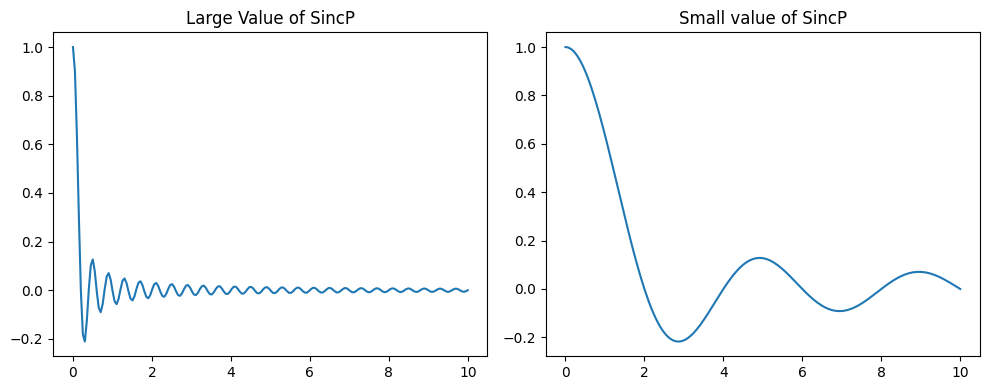

In [530]:
# we see the effect of changing the value of SincP
y1 = np.sinc(5*x)
y2 = np.sinc(0.5*x)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first graph on the first subplot
ax1.plot(x, y1)
ax1.set_title('Large Value of SincP')

# Plot the second graph on the second subplot
ax2.plot(x, y2)
ax2.set_title('Small value of SincP')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

#### Creating the signals recieved by each speaker

In [531]:
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)
print(signal_array)

[[-0.00753158  0.00685263  0.01755775 ...  0.00895899  0.00911974
   0.00392603]
 [ 0.0006176   0.01393414  0.01929061 ...  0.00978867  0.00666843
  -0.00031786]
 [ 0.0085314   0.01824499  0.01730163 ...  0.00873358  0.00305047
  -0.0043368 ]
 ...
 [ 0.01285111  0.00271241 -0.00930798 ... -0.00617336 -0.01063717
  -0.00878807]
 [ 0.01552015  0.01127398  0.00017021 ...  0.00029074 -0.0075215
  -0.01079047]
 [ 0.01221453  0.01541475  0.00946525 ...  0.00678156 -0.00141036
  -0.00863484]]


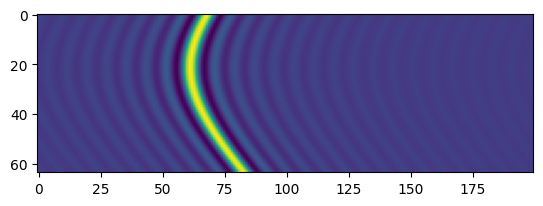

In [532]:
# creating a heat map of the mic signals
plt.imshow(signal_array)

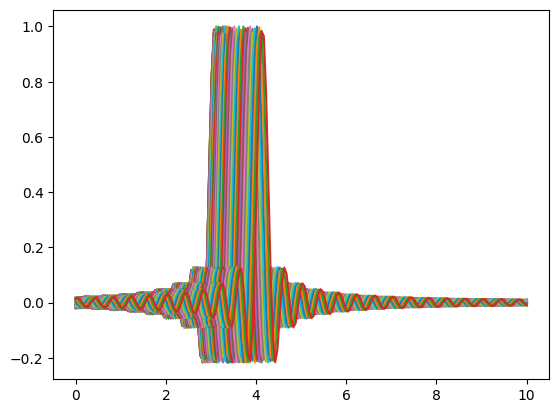

In [533]:
for i in range (len(mics)):
    plt.plot(x, signal_array[i])

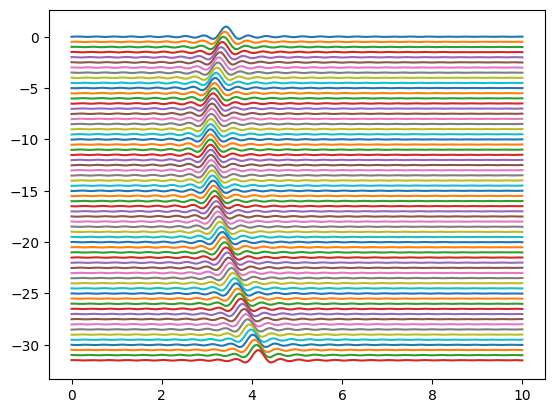

In [534]:
# The above graph occurs as all the signals for each mic has been overlaid. To separate and see them clearly, we add an offset
for i in range (len(mics)):
    plt.plot(x, signal_array[i] - 0.5*i)

#### Implementing the Delay-and-Sum algorithm

In [535]:
# creating the empty image
total_image = np.zeros((Nmics, Nsamp // 2))

#iterating over all the points
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]
print(total_image)        

[[ 6.12159902e+00  6.14885124e+00  6.12412797e+00 ... -3.40568707e-02
   0.00000000e+00  0.00000000e+00]
 [ 6.81381194e+00  6.85984208e+00  6.88077721e+00 ...  2.27038622e-02
   0.00000000e+00  0.00000000e+00]
 [ 6.55775264e+00  6.59232984e+00  6.65269051e+00 ...  2.13685365e-02
   0.00000000e+00  0.00000000e+00]
 ...
 [ 3.49250203e+00  3.52208492e+00  3.53807137e+00 ...  8.58949588e-03
   0.00000000e+00  0.00000000e+00]
 [ 3.11154439e+00  3.13733973e+00  3.13375591e+00 ...  5.52702881e-03
   0.00000000e+00  0.00000000e+00]
 [ 3.04050582e+00  3.06196244e+00  3.04089225e+00 ... -4.69883078e-02
   0.00000000e+00  0.00000000e+00]]


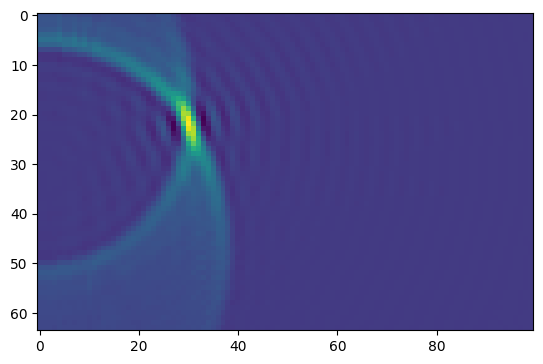

In [536]:
# generating a heat map of the image
plt.imshow(total_image)

# Questions

Q: The (x, y) coordinates corresponding to the maximum amplitude (yellow colour) is approximately (30, 22). Explain why this is the correct expected position for the given obstacle. \
A: This occurs as it represents the (30, 22) point in the matrix, which the origin mentioned above. The in scale of the axes, and the origin, causes the coordinate shift. The x coordinate would be 3 / distance_per_sample = 3 / 0.1 = 30, and y = 22 as it is in front of the 23rd mic.

Q: Does it make sense to reconstruct up to Nsamp? What value is more reasonable as an upper limit for the x-axis here? \
A:  It does not make sense to take points upto Nsamp as the delay for such points would be al least 2 * Nsamp, and thus we would not be able to get the corresponding signal for the same. Instead, reconstructing until Nsamp / 2, or its integral value, gives us an worst case upper limit to the number of points, and even this point can only be reconstructed from the mic placed at the origin, if any, as it is Nsamp * dist_per_samp away from the origin.

Q: What happens if C is different - if C is decreased it looks like the image becomes sharper. Can you explain why intuitively? \
A: Let us first observe this in the code:

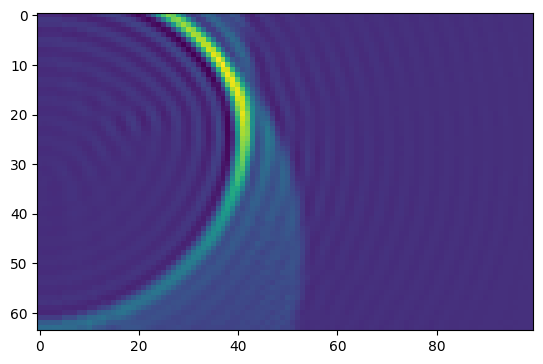

In [537]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200
C = 1.5

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)

This is because as the sampling range increases, we get more information and thus the image becomes sharper. When C decreases, we get more samples for the same distance, and thus image becomes sharper.

Q: What is the maximum obstacle x- and y- coordinate that you can use and still have an image reconstructed? \
A: As explained above, the maximum obstacle x coordinate would be $\frac{Nsamp \, * \, d}{2}$, where d is the distance between samples. Seeing the origin placement in the above heatmap, it is evident that the maximum y coordinate of the obstacle can be Nmics * pitch.

Q: What happens if Nmics is increased or decreased? Do the experiments with Nmics = [8, 32, 64] and Nsamp = [50, 100, 200] (all combinations). Attach the resulting images. \
A: The following graphs showcase the same:

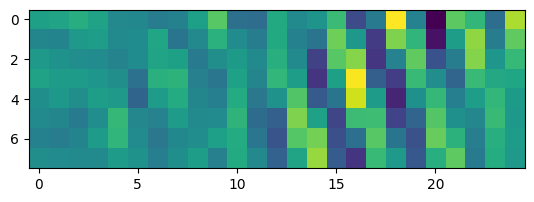

In [538]:
# Main system parameters: number of mics, number of samples in time
Nmics = 8
Nsamp = 50

t = Nsamp * dist_per_samp / C

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)
plt.savefig("8,50.jpg")

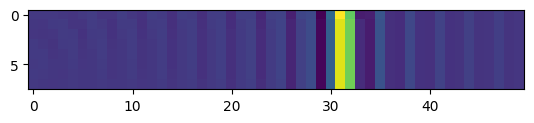

In [539]:
# Main system parameters: number of mics, number of samples in time
Nmics = 8
Nsamp = 100

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)
plt.savefig("8,100.jpg")

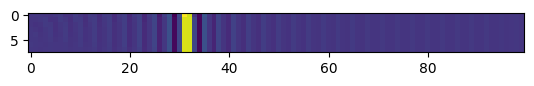

In [540]:
# Main system parameters: number of mics, number of samples in time
Nmics = 8
Nsamp = 200

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)
plt.savefig("8,200.jpg")

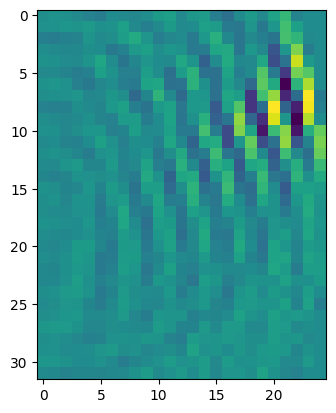

In [541]:
# Main system parameters: number of mics, number of samples in time
Nmics = 32
Nsamp = 50

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)
plt.savefig("32,50.jpg")

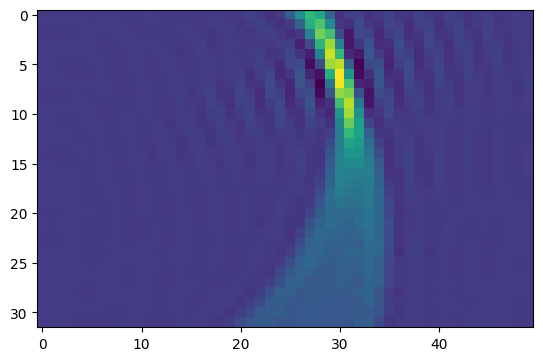

In [542]:
# Main system parameters: number of mics, number of samples in time
Nmics = 32
Nsamp = 100

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)
plt.savefig("32,100.jpg")

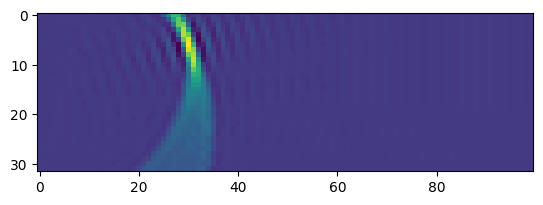

In [543]:
# Main system parameters: number of mics, number of samples in time
Nmics = 32
Nsamp = 200

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)
plt.savefig("32,200.jpg")

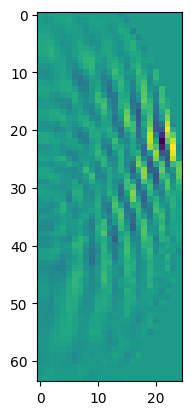

In [544]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 50

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)
plt.savefig("64,50.jpg")

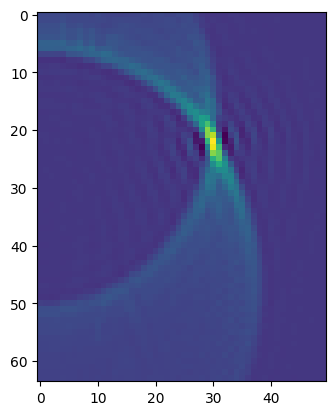

In [545]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 100

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)
plt.savefig("64,100.jpg")

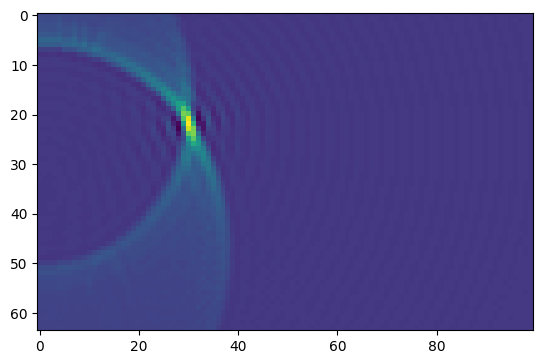

In [546]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = []
x = np.linspace(0, t, Nsamp)
for mic in mics:
    # delaying the signal by an appropriate amount
    signal_array.append(wsrc(x - (dist(src, obstacle, mic) / C)))
signal_array = np.asarray(signal_array, dtype = np.float32)

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)
plt.savefig("64,200.jpg")

Evidently, as the number of mics increase, the clarity of the image also increases due to more sampling and more information extraction.

## File rx2

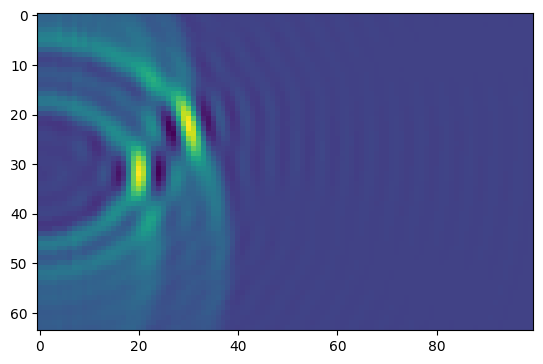

In [547]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200
dist_per_samp = 0.1
C = 0.5

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = np.loadtxt('rx2.txt')

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)

## File rx3

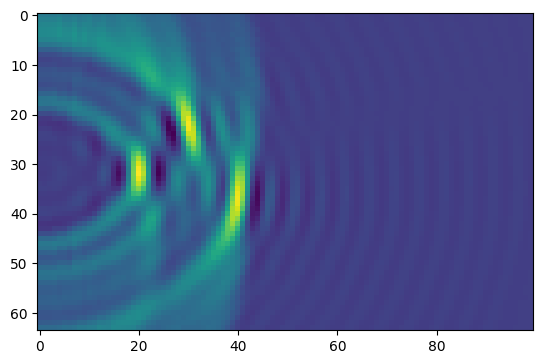

In [548]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200
dist_per_samp = 0.1
C = 0.5

t = Nsamp * dist_per_samp / C

# Locations of microphones
distance = pitch * (Nmics - 1)
mics = np.linspace (-distance / 2, distance / 2, Nmics)

# creating the signal array
signal_array = np.loadtxt('rx3.txt')

# building up the reconstructed image
total_image = np.zeros((Nmics, Nsamp // 2))
for i in range (Nmics):
    for j in range (Nsamp//2):
        for k in range(len(mics)):
            # creating the coordinates for the point
            x = j * dist_per_samp
            y = (i - Nmics // 2 ) * pitch
            delay = (dist(src, (x, y), mics[k])) / dist_per_samp
            if (delay < Nsamp):
                # adding the sampled signal at the appropriate grid cell
                total_image[i, j] += signal_array[k][int(delay)]

# generating a heat map of the image
plt.imshow(total_image)